In [275]:
import os
import os.path as osp
import json
from datetime import datetime
from pprint import pprint
from scipy.misc import imread, imresize
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 10)

### VIST directory

In [36]:
annotations_dir = '/playpen/data/vist/annotations'
images_dir = '/playpen/data/vist/images'

In [374]:
split = 'test'
# Load dii's split json
b = datetime.now()
path_to_dii_val = osp.join(annotations_dir, 'dii', split+'.description-in-isolation.json')
dii = json.load(open(path_to_dii_val))
print 'dii\'s [%s] loaded. It took %.2f seconds.' % (split, (datetime.now() - b).total_seconds())

# Load sis's split json
b = datetime.now()
path_to_sis_val = osp.join(annotations_dir, 'sis', split+'.story-in-sequence.json')
sis = json.load(open(path_to_sis_val))
print 'sis\'s [%s] loaded. It took %.2f seconds.' % (split, (datetime.now() - b).total_seconds())

dii's [test] loaded. It took 0.38 seconds.
sis's [test] loaded. It took 0.49 seconds.


In [375]:
# Let's check one ann
sis.keys()

[u'images', u'info', u'albums', u'type', u'annotations']

In [376]:
sis['annotations'][0]

[{u'album_id': u'44277',
  u'original_text': u'The local parish holds a craft show each year.',
  u'photo_flickr_id': u'1741642',
  u'setting': u'first-2-pick-and-tell',
  u'story_id': u'45530',
  u'storylet_id': u'227650',
  u'text': u'the local parish holds a craft show each year .',
  u'tier': u'story-in-sequence',
  u'worker_arranged_photo_order': 0,
  u'worker_id': u'FJROI8NWDRIPAM1'}]

In [435]:
sis['images'][0]

{u'album_id': u'44277',
 u'datetaken': u'2004-11-27 10:40:46',
 u'id': u'1741642',
 u'latitude': u'51.920449',
 u'license': u'1',
 u'longitude': u'-0.212688',
 u'media': u'photo',
 u'secret': u'81837e8e9e',
 u'tags': u'stevenage fairies craftfair xmas 2004',
 u'text': u'',
 u'title': u'The venue.',
 u'url_o': u'https://farm1.staticflickr.com/2/1741642_81837e8e9e_o.jpg'}

In [399]:
sis['albums'][3]

{u'date_create': u'1220783782',
 u'date_update': u'1306981520',
 u'description': u"Photo's from Father's Day 2008 at Tread, Wangaratta",
 u'farm': u'4',
 u'id': u'72157607155047588',
 u'owner': u'50148267@N00',
 u'photos': u'19',
 u'primary': u'2835931462',
 u'secret': u'fa6c97bfe2',
 u'server': u'3010',
 u'title': u"Father's Day 2008",
 u'vist_label': u"father's_day"}

In [362]:
def show_album(alb_id):
    img_ids = alb_to_img_ids[alb_id]
    plt.figure()
    cols = 5
    rows = math.ceil(len(img_ids)/float(cols))
    for i, img_id in enumerate(img_ids):
        img = Images[img_id]
        img_file = osp.join(images_dir, split, img['id']+'.jpg')
        img_content = imread(img_file)
        img_content = imresize(img_content, (224, 224))
        ax = plt.subplot(rows, cols, i+1)
        ax.imshow(img_content)
        ax.axis('off')
#         ax.set_title(str(img_id))
        ax.set_title(str(img_id)+'\n'+img['datetaken'][4:])
    plt.show()

In [432]:
def show_story(story_id, show_image=True):
    sent_ids = story_to_sent_ids[story_id]
    if show_image:
        plt.figure()
        for i, sent_id in enumerate(sent_ids):
            img_id = Sents[sent_id]['img_id']
            img = Images[img_id]
            img_file = osp.join(images_dir, split, str(img_id)+'.jpg')
            img_content = imread(img_file)
            img_content = imresize(img_content, (224, 224))
            ax = plt.subplot(1, len(sent_ids), i+1)
            ax.imshow(img_content)
            ax.axis('off')
            ax.set_title(str(img_id)+'\n'+img['datetaken'][5:])
        plt.show()
    for sent_id in sent_ids:
        sent = Sents[sent_id]
        print 'order[%s], image_id[%s], text[%s]' % (sent['order'], sent['img_id'], sent['original_text'])

In [361]:
Images = {item['id']: item for item in sis['images']}
Albums = {item['id']: item for item in sis['albums']}
alb_to_img_ids = {}
for item in sis['images']:
    alb_id = item['album_id']
    img_id = item['id']
    alb_to_img_ids[alb_id] = alb_to_img_ids.get(alb_id, []) + [img_id]

# sort img_ids based on datetime
def getDateTime(img_id):
    x = Images[img_id]['datetaken']
    return datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
for alb_id, img_ids in alb_to_img_ids.items():
    img_ids.sort(key=getDateTime)

In [364]:
# make sents = [{}]
sents = []
for ann in sis['annotations']:
    sent = ann[0].copy()
    sent['id'] = sent.pop('storylet_id')
    sent['order'] = sent.pop('worker_arranged_photo_order')
    sent['img_id'] = sent.pop('photo_flickr_id')
    sents += [sent]
Sents = {sent['id']: sent for sent in sents}

# story_id -> sent_ids
story_to_sent_ids = {}
for sent_id, sent in Sents.items():
    story_id = sent['story_id']
    story_to_sent_ids[story_id] = story_to_sent_ids.get(story_id, []) + [sent_id]

def get_order(sent_id):
    return Sents[sent_id]['order']
for story_id, sent_ids in story_to_sent_ids.items():
    sent_ids.sort(key=get_order)
    
# alb_id -> story_ids
alb_to_story_ids = {}
for story_id, sent_ids in story_to_sent_ids.items():
    sent = Sents[sent_ids[0]]
    alb_id = sent['album_id']
    alb_to_story_ids[alb_id] = alb_to_story_ids.get(alb_id, []) + [story_id]

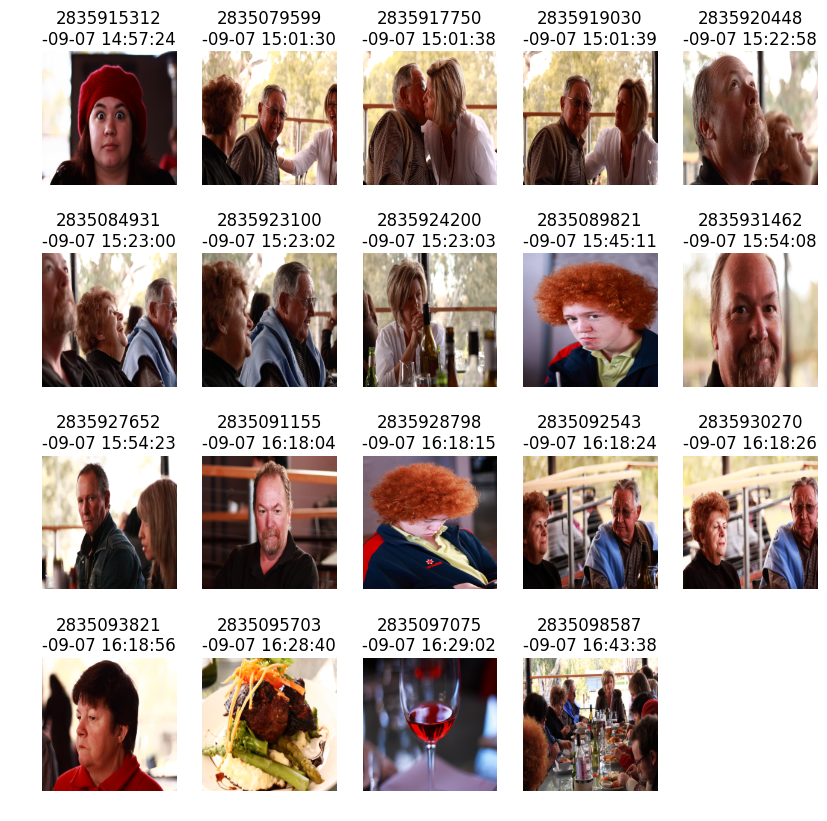

In [400]:
alb_id = '72157607155047588'
show_album(alb_id)

This album has 5 stories.


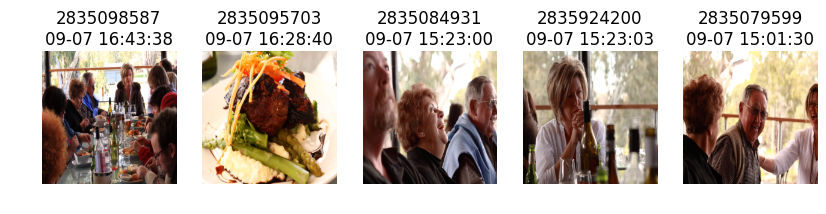

order[0], image_id[2835098587], text[A look down the table at our family gathering.]
order[1], image_id[2835095703], text[The food looked amazing at the meal.]
order[2], image_id[2835084931], text[Mom and Dad seemed to be having a wonderful time.]
order[3], image_id[2835924200], text[Carol starred deeply into the wine bottle.]
order[4], image_id[2835079599], text[Dad cracked one of his famous dirty jokes.]


In [433]:
story_ids = alb_to_story_ids[alb_id]
print 'This album has %s stories.' % len(story_ids)
show_story(story_ids[4], True)

In [368]:
# alb_ids = Albums.keys()
# alb_id = alb_ids[2]; print alb_id
# show_album(alb_id)

In [ ]:
sis['type']

In [ ]:
dii.keys()

In [ ]:
pprint(dii['annotations'][0][0])
pprint(dii['annotations'][5][0])

In [428]:
sis['annotations'][0][0]

{u'album_id': u'44277',
 u'original_text': u'The local parish holds a craft show each year.',
 u'photo_flickr_id': u'1741642',
 u'setting': u'first-2-pick-and-tell',
 u'story_id': u'45530',
 u'storylet_id': u'227650',
 u'text': u'the local parish holds a craft show each year .',
 u'tier': u'story-in-sequence',
 u'worker_arranged_photo_order': 0,
 u'worker_id': u'FJROI8NWDRIPAM1'}

In [410]:
sis['albums'][0]['id']

u'44277'

In [417]:
for i in range(len(sis['albums'])):
    if not sis['albums'][i]['id'] == dii['albums'][i]['id']:
        print 'inconsitancy found.'

In [418]:
sis['albums'][0]

{u'date_create': u'44277',
 u'date_update': u'1396811566',
 u'description': u"I left Stevenage over twenty years ago, having lived there between the ages of 7 and 20. Yesterday (on International Buy Nothing Day!) we returned for a 'Victorian Craft Fair' in the Church above the town Museum. Very strange...",
 u'farm': u'1',
 u'id': u'44277',
 u'owner': u'37996585435@N01',
 u'photos': u'23',
 u'primary': u'1741611',
 u'secret': u'3f374c96e5',
 u'server': u'2',
 u'title': u'A trip to Stevenage',
 u'vist_label': u'fair'}

In [427]:
sis['images'][7]['id']

u'1741627'

In [459]:
sis['annotations'][14]

[{u'album_id': u'44277',
  u'original_text': u'It makes them sad.',
  u'photo_flickr_id': u'1741587',
  u'setting': u'last-3-pick-old-and-tell',
  u'story_id': u'45532',
  u'storylet_id': u'227664',
  u'text': u'it makes them sad .',
  u'tier': u'story-in-sequence',
  u'worker_arranged_photo_order': 4,
  u'worker_id': u'351958JM3YVRMQL'}]

In [458]:
dii['annotations'][14]

[{u'album_id': u'44277',
  u'original_text': u'A man wearing a top hat kneeling on the floor.',
  u'photo_flickr_id': u'1741587',
  u'photo_order_in_story': 4,
  u'text': u'a man wearing a top hat kneeling on the floor .',
  u'tier': u'descriptions-in-isolation',
  u'worker_id': u'UNUY9179WKUI6Y9'}]

In [462]:
for i in range(len(sis['annotations'][:2])):
    sd = sis['annotations'][i][0]
    dd = dii['annotations'][i][0]
    if sd['album_id'] != dd['album_id'] or sd['photo_flickr_id'] != dd['photo_flickr_id']  \
        or sd['worker_arranged_photo_order'] != dd['photo_order_in_story']:
            print 'k'